In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time 
from tqdm import tqdm
import pandas as pd

In [2]:
from numba import njit

In [3]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(loc=0.0, scale=1.0, size=M))
    
    return S

In [4]:
def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)

In [5]:
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), norm.cdf(d1)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1), -norm.cdf(-d1)

In [6]:
S0 = 50                                 # Initial stock price
K = 50                                  # Strike price
mu = 0.06                               # Risk free rate
sigma = 0.2                             # Volatility
T = 1                                   # Time to maturity
N = 4                                   # Number of monitoring dates
M = 5000                                # Number of sample paths

In [7]:
black_scholes(S0, K, mu, sigma, T, option_type='put')

(2.5830012555254314, -0.3445782583896758)

In [8]:
def binomial_option_pricing(S, K, T, r, sigma, N, monitoring_dates, option_type='call'):
    dt = T / N  # Length of each time interval
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    q = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize arrays to store stock prices and option values
    stock_prices = np.zeros((N+1, N+1))
    option_values = np.zeros((N+1, N+1))

    # Initialize stock prices at maturity
    for i in range(N+1):
        for j in range(i+1):
            stock_prices[i, j] = S * (u**j) * (d**(i-j))

    # Calculate payoff at maturity
    if option_type == 'call':
        option_values[N, :] = np.maximum(stock_prices[N, :] - K, 0)
    else:  # put
        option_values[N, :] = np.maximum(K - stock_prices[N, :], 0)

    # Backward recursion for option price
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            if i*dt in monitoring_dates:
                continuation_value = (q * option_values[i+1, j+1] + (1-q) * option_values[i+1, j]) * np.exp(-r * dt)
                if option_type == 'call':
                    option_values[i, j] = np.maximum(stock_prices[i, j] - K, continuation_value)
                else:
                    option_values[i, j] = np.maximum(K - stock_prices[i, j], continuation_value)
            else:
                option_values[i, j] = (q * option_values[i+1, j+1] + (1-q) * option_values[i+1, j]) * np.exp(-r * dt)
    delta = (option_values[1, 1] - option_values[1, 0])/(stock_prices[1, 1] - stock_prices[1, 0])

    return option_values[0,0], delta#, stock_prices

In [9]:
binomial_option_pricing(S0, K, T, mu, sigma, 100, [0,0.25, 0.5, 0.75, 1], option_type='put')

(2.81889159146015, -0.3971209544812329)

In [17]:
def calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 10000):
    hedge_error = np.zeros(M)
    for m in tqdm(range(M)):
        V0, delta = binomial_option_pricing(S0, K, T, mu, sigma, 100, monitoring_dates, option_type='put')
        #print(f'Price of the option: {V0}', f'Delta: {delta}')
        cash_flow = V0 - delta * S0
        No_of_shares = delta
        updated_monitoring_dates = monitoring_dates
        #print(f'Initial cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
        S = stock_price_simulator(S0, mu, sigma, T, hedge_freq, 1).flatten()
        #print(S)
        dt = T/hedge_freq
        #print("time stpes in hedging dates", dt)
        for i in range(1, len(hedging_dates)- 1):
            #print(f'Hedging date: {i*dt}')
            updated_monitoring_dates = updated_monitoring_dates - dt
            updated_monitoring_dates = updated_monitoring_dates[updated_monitoring_dates > 0]    
            #print(f'Updated monitoring dates: {updated_monitoring_dates}')
            V1, delta2 = binomial_option_pricing(S[i], K, updated_monitoring_dates[-1], mu, sigma, 100, updated_monitoring_dates, option_type='put')
            if i*dt in monitoring_dates:
                #print("inside", i*dt)
                #print(f'Price of stock: {S[i]}', f'Price of the option: {V1}', f'K: {K}', f'payoff : {payoff_fun(S[i], K, "put")}')
                if payoff_fun(S[i], K, 'put') > V1:
                    #print("Exercise")
                    break
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print(f'Cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
            else:
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print("Not in monitoring date")
            #print("i", i, No_of_shares)
        if i == len(hedging_dates)-2:
            #print("Last date", i)
            payoff_last = payoff_fun(S[i+1], K, 'put')   
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i+1]
        else:
            #print("i at end", i)
            payoff_last = payoff_fun(S[i], K, 'put')
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i]
        #print(f'Final Hedge Error: {payoff_last - final_cash_flow}')
        hedge_error[m] = payoff_last - final_cash_flow
        
    return hedge_error

In [46]:
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
M = 5000
hedging_error = calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M)


100%|██████████| 5000/5000 [15:07<00:00,  5.51it/s]


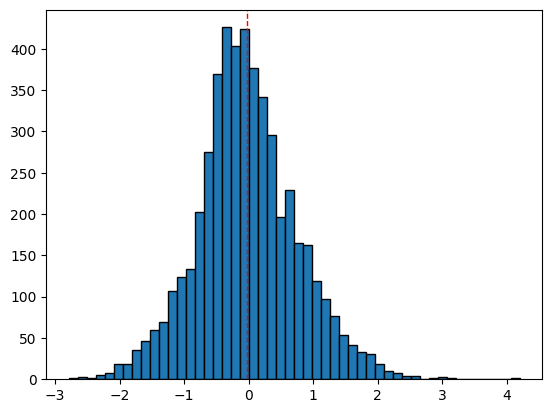

In [47]:
hedging_error = np.array(hedging_error)
plt.hist(hedging_error, bins=50, edgecolor='black')
plt.axvline(hedging_error.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

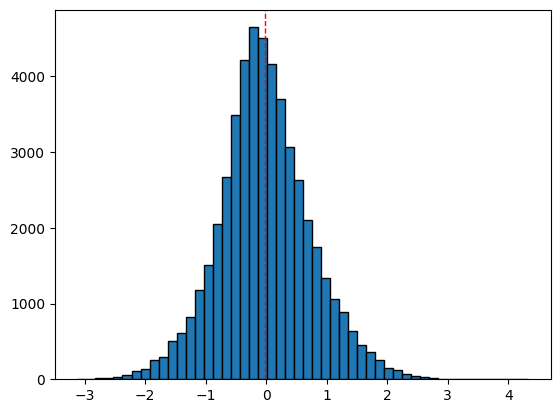

In [136]:
## Using Numba with 50000 simulations and hedge frequency of 24
hedging_error = np.array(hedging_error)
plt.hist(hedging_error, bins=50, edgecolor='black')
plt.axvline(hedging_error.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [24]:
S0 = 50
K = 1.2 * S0
mu = 0.06
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
M = 20000
hedging_error_120 = calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M)


100%|██████████| 20000/20000 [31:21<00:00, 10.63it/s]


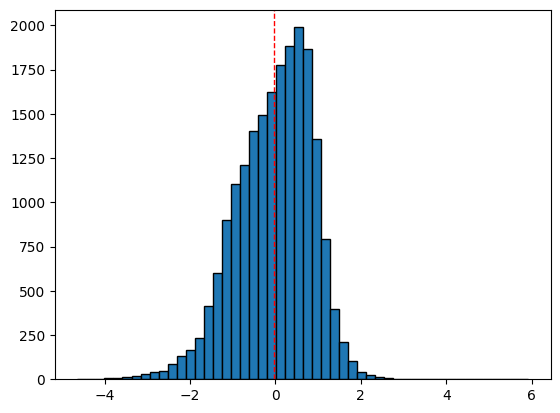

In [25]:
plt.hist(hedging_error_120, bins=50, edgecolor='black')
plt.axvline(hedging_error_120.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

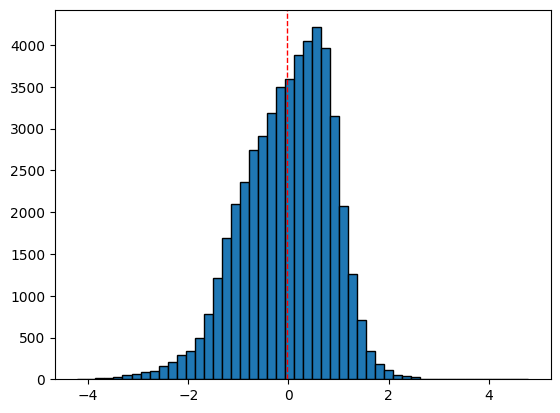

In [140]:
## Using Numba with 50000 simulations and hedge frequency of 24
plt.hist(hedging_error_120, bins=50, edgecolor='black')
plt.axvline(hedging_error_120.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [29]:
S0 = 50
K = 0.8 * S0
mu = 0.06
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
M = 5000
hedging_error_80 = calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M)

100%|██████████| 5000/5000 [18:17<00:00,  4.55it/s]


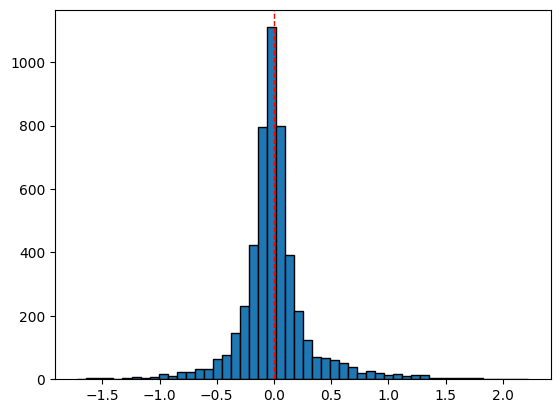

In [30]:
plt.hist(hedging_error_80, bins=50, edgecolor='black')
plt.axvline(hedging_error_80.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
## Using Numba with 50000 simulations and Hedging frequency of 24
plt.hist(hedging_error, bins=50, label='K /S0= 1', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error), color='r', linestyle='dashed', linewidth=1, label='K/S0=1 Mean')
plt.hist(hedging_error_80, bins=50, label='K /S0= 0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label='K/S0=0.8 Mean')
plt.hist(hedging_error_120, bins=50, label='K /S0= 1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label='K/S0=1.2 Mean')
plt.legend()
plt.savefig('Hedge_error_freq24_sample5000.jpeg')
plt.show()

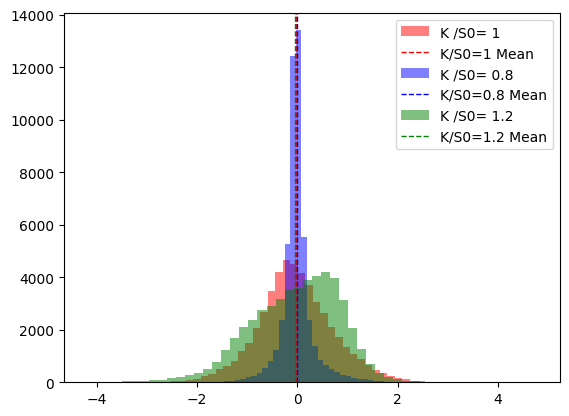

In [139]:
## Using Numba with 50000 simulations and Hedging frequency of 24
plt.hist(hedging_error, bins=50, label='K /S0= 1', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error), color='r', linestyle='dashed', linewidth=1, label='K/S0=1 Mean')
plt.hist(hedging_error_80, bins=50, label='K /S0= 0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label='K/S0=0.8 Mean')
plt.hist(hedging_error_120, bins=50, label='K /S0= 1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label='K/S0=1.2 Mean')
plt.legend()
plt.show()

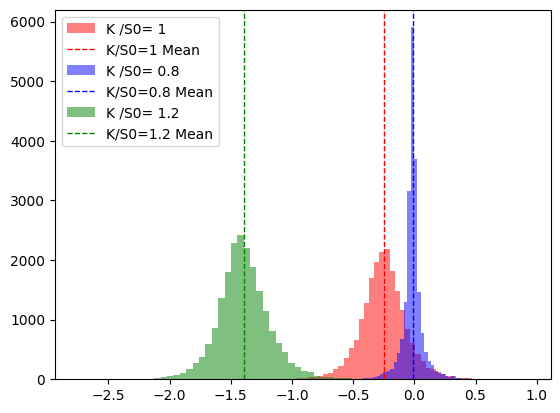

In [291]:
plt.hist(hedging_error, bins=50, label='K /S0= 1', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error), color='r', linestyle='dashed', linewidth=1, label='K/S0=1 Mean')
plt.hist(hedging_error_80, bins=50, label='K /S0= 0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label='K/S0=0.8 Mean')
plt.hist(hedging_error_120, bins=50, label='K /S0= 1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label='K/S0=1.2 Mean')
plt.legend()
plt.show()

#### Parallel Version

In [38]:
from multiprocessing import Pool
from tqdm import tqdm
from simulations import run_simulation  # Import the simulation function

In [32]:
import os

In [33]:
os.cpu_count()

11

In [39]:
def main_parallel(num_simulations, S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates):
    params = [(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates) for _ in range(num_simulations)]
    # Utilize all available CPU cores
    num_cores = os.cpu_count()
    with Pool(num_cores) as pool:
        results = list(tqdm(pool.imap(run_simulation, params), total=num_simulations))
    return results


In [144]:
hedge_errors = np.array(hedge_errors)
np.mean(hedge_errors), np.std(hedge_errors)

(-0.20070974833217337, 0.1867082667124075)

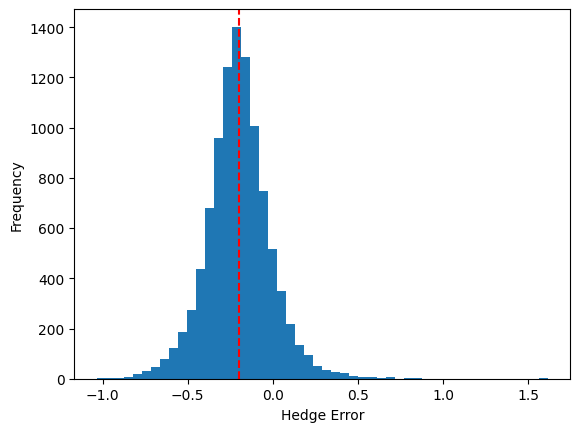

In [148]:
plt.hist(hedge_errors, bins=50)
plt.axvline(np.mean(hedge_errors), color='red', linestyle='--')
plt.xlabel('Hedge Error')
plt.ylabel('Frequency')
plt.show()

In [40]:
## 80% of the strike price In the money Option K/S0 = 0.8
if __name__ == '__main__':
    S0 =40
    K = 0.8*S0
    T = 1
    mu = 0.06
    sigma = 0.2
    num_simulations = 1000
    hedge_freq = 252
    monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
    hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
    hedge_errors_80 = main_parallel(num_simulations, S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates)
    print("Simulation completed.")

100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]

Simulation completed.


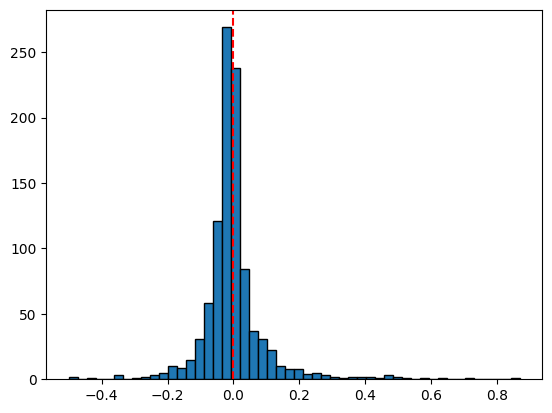

In [41]:
plt.hist(hedge_errors_80, bins=50, edgecolor='black')
plt.axvline(np.mean(hedge_errors_80), color='red', linestyle='--')
plt.show()

In [42]:
## 120% of the strike price Out of the money Option K/S0 = 1.2
if __name__ == '__main__':
    S0 =40
    K = 1.2*S0
    T = 1
    mu = 0.06
    sigma = 0.2
    hedge_freq = 52
    monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
    hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
    num_simulations = 1000
    hedge_errors_120 = main_parallel(num_simulations, S0, K, T, mu, sigma, hedge_freq, monitoring_dates, hedging_dates)
    print("Simulation completed.")

100%|██████████| 1000/1000 [01:08<00:00, 14.65it/s]

Simulation completed.


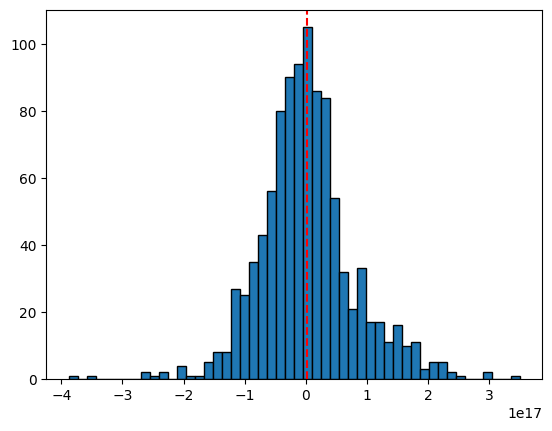

In [43]:
plt.hist(hedge_errors_120, bins=50, edgecolor='black')
plt.axvline(np.mean(hedge_errors_120), color='red', linestyle='--')
plt.show()

In [154]:
### 100% of the Strike Price At the money option K/S0 = 1
if __name__ == '__main__':
    S0 =40
    K = S0
    T = 1
    mu = 0.06
    sigma = 0.2
    num_simulations = 10000
    hedge_errors = main_parallel(num_simulations, S0, K, T, mu, sigma)
    print("Simulation completed.")

100%|██████████| 5000/5000 [05:41<00:00, 14.66it/s]

Simulation completed.


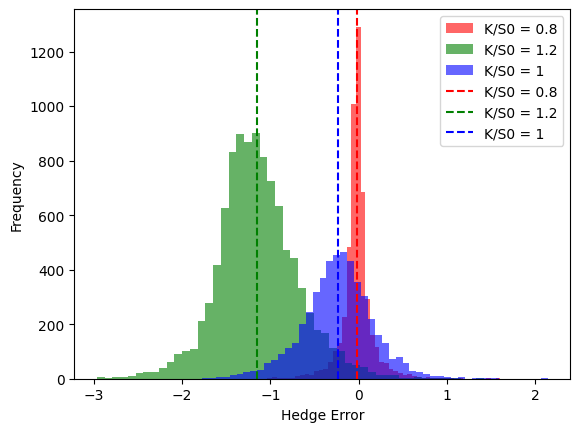

In [164]:
hedge_errors_80 = np.array(hedge_errors_80)
hedge_errors_120 = np.array(hedge_errors_120)
hedge_errors = np.array(hedge_errors)
plt.hist(hedge_errors_80, bins=50, label='K/S0 = 0.8', color='red', alpha = 0.6)
plt.hist(hedge_errors_120, bins=50, label='K/S0 = 1.2', color='green', alpha = 0.6)
plt.hist(hedge_errors, bins=50, label='K/S0 = 1', color='blue', alpha = 0.6)
plt.axvline(np.mean(hedge_errors_80), linestyle='--', label="K/S0 = 0.8", color='red')
plt.axvline(np.mean(hedge_errors_120), linestyle='--', label='K/S0 = 1.2', color='green')
plt.axvline(np.mean(hedge_errors), linestyle='--', label='K/S0 = 1', color='blue')
plt.xlabel('Hedge Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()
